<img src="https://github.com/hernancontigiani/ceia_memorias_especializacion/raw/master/Figures/logoFIUBA.jpg" width="500" align="center">


# Procesamiento de lenguaje natural

# Desafío 2: Custom embedddings con Gensim



## Consigna

1. Crear sus propios vectores con Gensim [basado en lo visto en clase](https://github.com/FIUBA-Posgrado-Inteligencia-Artificial/procesamiento_lenguaje_natural/blob/main/clase_2/jupyter_notebooks/2c%20-%20Custom%20embedding%20con%20Gensim.ipynb) con otro dataset.
1. Probar términos de interés y explicar similitudes en el espacio de embeddings (sacar conclusiones entre palabras similitudes y diferencias).
1. Plantear y probar tests de analogías.
1. Graficar los embeddings resultantes.
1. Obtener conclusiones.

## Resolución

### 1. Crear sus propios vectores con Gensim [basado en lo visto en clase](https://github.com/FIUBA-Posgrado-Inteligencia-Artificial/procesamiento_lenguaje_natural/blob/main/clase_2/jupyter_notebooks/2c%20-%20Custom%20embedding%20con%20Gensim.ipynb) con otro dataset.

- Dataset a utilizar: recetas de cocina extraídas del subreddit /recipes
  - Fuente: https://www.kaggle.com/datasets/michau96/recipes-from-reddit

Imports de librerías a utilizar

In [7]:
import pandas as pd
import csv
import matplotlib.pyplot as plt
import seaborn as sns

import multiprocessing
from gensim.models import Word2Vec

Carga del dataset

- Se utiliza el path absoluto del dataset cargado en google drive.

In [16]:
# Armar el dataset utilizando salto de línea para separar las oraciones/docs
df = pd.read_csv('https://drive.google.com/uc?export=download&id=11e9BsbznVjbgZTjbof_3-aZTfSMEj2Oq',encoding='latin')
df.head()

,comment
0,"This is by no means ""authentic"" tiramisu in th..."
1,"Thank you for the great idea, u/oliveyoil!\r\n..."
2,**Homemade Cinnamon Rolls**\r\n\r\nLayers of s...
3,\r\n\r\nOne of my favorite at home dessert re...
4,I am obsessed with making different ramen dish...


- Se utiliza sólo la columna "comment" donde se encuentran las recetas escritas por los usuarios.

In [17]:
documents_df = df["comment"]
print("Cantidad de documentos:", documents_df.shape[0])
documents_df.head()


Cantidad de documentos: 918


,comment
0,"This is by no means ""authentic"" tiramisu in th..."
1,"Thank you for the great idea, u/oliveyoil!\r\n..."
2,**Homemade Cinnamon Rolls**\r\n\r\nLayers of s...
3,\r\n\r\nOne of my favorite at home dessert re...
4,I am obsessed with making different ramen dish...


#### Preprocesamiento

- Se recorren todas las recetas.
- Se remueven ciertos caracteres que no son de interés (como #), ya que el texto extraído de reddit viene en formato markdown

In [30]:
from tensorflow.keras.preprocessing.text import text_to_word_sequence
import re

# Defino funcion para limpiar texto a mano.
def clean_text(text):
    """Remueve caracteres encontrados en textos formateados en markdown."""
    text = re.sub(r'#', '', text)    
    text = re.sub(r'\n', ' ', text)  
    text = re.sub(r'\s+', ' ', text) #Reemplazo multi-espacios por un solo espacio
    return text.strip()

sentence_tokens = []

for recipe in documents_df:
    clean_recipe = clean_text(recipe)
    tokens = text_to_word_sequence(clean_recipe)
    sentence_tokens.append(tokens)

In [31]:
# Demos un vistazo
sentence_tokens[:2]

[['this',
  'is',
  'by',
  'no',
  'means',
  'authentic',
  'tiramisu',
  'in',
  'that',
  'it',
  'has',
  'no',
  'raw',
  'eggs',
  'but',
  "it's",
  'just',
  'as',
  'tasty',
  'easy',
  'tiramisu',
  'recipe',
  'no',
  'raw',
  'eggs',
  'ingredients',
  'about',
  '1',
  '5',
  'packages',
  'worth',
  'of',
  'lady',
  'fingers',
  'i',
  'got',
  'mine',
  'at',
  'an',
  'italian',
  'market',
  'ran',
  'out',
  'and',
  'then',
  'had',
  'my',
  'husband',
  'run',
  'out',
  'to',
  'get',
  'more',
  'at',
  'whole',
  'foods',
  'he',
  'got',
  'the',
  'store',
  'brand',
  'which',
  'is',
  'also',
  'imported',
  'from',
  'italy',
  'make',
  'sure',
  'these',
  'are',
  'the',
  'hard',
  'lady',
  'fingers',
  'not',
  'the',
  'soft',
  'ones',
  '2',
  'c',
  'strong',
  'coffee',
  'espresso',
  '9',
  'tbsp',
  'rum',
  'or',
  'marsala',
  'wine',
  'you',
  'can',
  'half',
  'this',
  'for',
  'a',
  'less',
  'pronounced',
  'alcoholic',
  'flavor'

#### Creación de los vectores usando modelo *word2vec*
- Se usa un callback propia para informar loss durante el entrenamiento.
  - Se agrega la opción de imprimir una curva loss VS epoch al terminar el entrenamiento.

In [69]:
from gensim.models.callbacks import CallbackAny2Vec
# Durante el entrenamiento gensim por defecto no informa el "loss" en cada época
# Sobrecargamos el callback para poder tener esta información
class callback(CallbackAny2Vec):
    """
    Callback to print loss after each epoch
    """
    def __init__(self):
        self.epoch = 0
        self.losses = []

    def on_train_end(self,model):
      # Plot loss vs. epoch
        plt.plot(self.losses, label='Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Loss vs Epoch')
        plt.legend()
        plt.show()



    def on_epoch_end(self, model):
        loss = model.get_latest_training_loss()
        if self.epoch == 0:
            print('Loss after epoch {}: {}'.format(self.epoch, loss))
            self.losses.append(loss)
        else:
            print('Loss after epoch {}: {}'.format(self.epoch, loss - self.loss_previous_step))
            self.losses.append(loss - self.loss_previous_step)
        self.epoch += 1
        self.loss_previous_step = loss

Primero se probará con Skipgram

In [62]:
# Crearmos el modelo generador de vectores
# Se elige la estructura del modelo Skipgram
w2v_model = Word2Vec(min_count=3,    # frecuencia mínima de palabra para incluirla en el vocabulario
                     window=2,       # cant de palabras antes y desp de la predicha
                     vector_size=50, # dimensionalidad de los vectores
                     negative=20,    # cantidad de negative samples... 0 es no se usa
                     workers=1,      # si tienen más cores pueden cambiar este valor
                     sg=1)           # modelo 0:CBOW  1:skipgram

In [63]:
# Obtener el vocabulario con los tokens
w2v_model.build_vocab(sentence_tokens)

In [64]:
# Cantidad de filas/docs encontradas en el corpus
print("Cantidad de docs en el corpus:", w2v_model.corpus_count)

Cantidad de docs en el corpus: 918


In [96]:
# Cantidad de words encontradas en el corpus
print("Cantidad de words distintas en el corpus:", len(w2v_model.wv.index_to_key))

Cantidad de words distintas en el corpus: 4378


#### Entrenamiento de embeddings

Loss after epoch 0: 1952486.625
Loss after epoch 1: 1794230.875
Loss after epoch 2: 1680022.0
Loss after epoch 3: 1640316.5
Loss after epoch 4: 1619788.0
Loss after epoch 5: 1534854.0
Loss after epoch 6: 1529875.0
Loss after epoch 7: 1530411.0
Loss after epoch 8: 1524542.0
Loss after epoch 9: 1522227.0
Loss after epoch 10: 1462749.0
Loss after epoch 11: 1431868.0
Loss after epoch 12: 1429258.0
Loss after epoch 13: 1428280.0
Loss after epoch 14: 1427598.0
Loss after epoch 15: 1426116.0
Loss after epoch 16: 1424406.0
Loss after epoch 17: 1421092.0
Loss after epoch 18: 1420680.0
Loss after epoch 19: 1416064.0
Loss after epoch 20: 1415620.0
Loss after epoch 21: 1415594.0
Loss after epoch 22: 1377506.0
Loss after epoch 23: 1374316.0
Loss after epoch 24: 1378824.0
Loss after epoch 25: 1374752.0
Loss after epoch 26: 1372980.0
Loss after epoch 27: 1372204.0
Loss after epoch 28: 1370624.0
Loss after epoch 29: 1375544.0


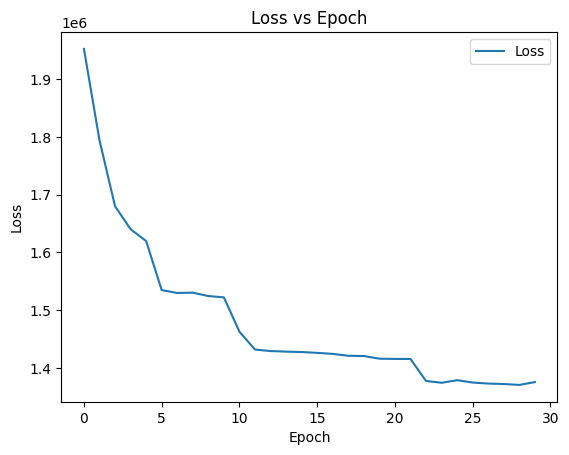

(6909788, 9299040)

In [95]:
# Entrenamos el modelo generador de vectores
# Utilizamos nuestro callback
w2v_model.train(sentence_tokens,
                 total_examples=w2v_model.corpus_count,
                 epochs=30,
                 compute_loss = True,
                 callbacks=[callback()]
                 )

### 2. Probar términos de interés y explicar similitudes en el espacio de embeddings (sacar conclusiones entre palabras similitudes y diferencias).

Palabras que más se relacionan con "rice"

In [91]:
# Palabras que MÁS se relacionan con...:
w2v_model.wv.most_similar(positive=["rice"], topn=10)

[('jasmine', 0.6917536854743958),
 ('glutinous', 0.6875026822090149),
 ('basmati', 0.6604378819465637),
 ('carnaroli', 0.6449130177497864),
 ('lentils', 0.6433275938034058),
 ('pasta', 0.6255998015403748),
 ('farro', 0.6221164464950562),
 ('lentil', 0.6194764971733093),
 ('boba', 0.6173975467681885),
 ('gochugaru', 0.6161437630653381)]

Las relaciones tienen sentido, analicemos las primeras 5 palabras:

- jasmine: Un tipo de arroz.
- glutinous: Una característica típica del arroz.
- basmati: Un tipo de arroz.
- carnaroli: Otro tipo de arroz.
- lentils: Lentejas, comparten una categoría de comida similar (legumbres / granos).


Ahora veamos las palabras que menos se relacionan con "oven":


In [92]:
# Palabras que MENOS se relacionan con...:
w2v_model.wv.most_similar(negative=["oven"], topn=10)

[('adds', 0.1366562396287918),
 ('preserved', 0.06563415378332138),
 ('types', 0.06248040497303009),
 ('noodle', 0.0584573820233345),
 ('bulgogi', 0.05445578321814537),
 ('3oz', 0.03738025575876236),
 ('kimchi', 0.030488863587379456),
 ('throughly', 0.02982449159026146),
 ('chickpea', 0.02948830835521221),
 ('yoghurt', 0.029332762584090233)]

- Las primeras 3 palabras casi que no tienen relación alguna.
- Aparecen comidas que no se cocinan dentro del horno como:
  - "noodle" (fideos).
  - "bulgogi" (carne coreana que se cocina en la sartén).
  - "kimchi" (verduras fermentada).
  - "chickpea" (garbanzos).
- Se obtiene yoghurt, un alimento que no lleva cocción alguna.

Palabras que se relacionan con "bread".

In [93]:
# Palabras que MÁS se relacionan con...:
w2v_model.wv.most_similar(positive=["bread"], topn=6)

[('stale', 0.6572244167327881),
 ('buckwheat', 0.6378626823425293),
 ('pecans', 0.634807288646698),
 ('sourdough', 0.6284531950950623),
 ('delightbaking', 0.6080353260040283),
 ('slices', 0.5983232855796814)]

- Stale: Se le dice "stale bread" al pan cuando aparecen manchas verdes (hongos).
- Buckwheat: Trigo sarraceno, que se utiliza para hacer pan integral.
- Pecans: Un tipo de nueces, seguramente haya recetas de pan donde agreguen este ingrediente.
- Sourdough: Pan de masa madre.
- Delightbaking: Página web que tiene recetas de cocina de pastelería y harinados, especialmente de panes.
- Slices: Rebanadas, término bastante común al hablar de pan.

Se repite el mismo procedimiento pero utilizando CBOW envés de Skipgram

In [97]:
# Crearmos el modelo generador de vectores, ahora con CBOW
w2v_model_cbow = Word2Vec(min_count=3,    # frecuencia mínima de palabra para incluirla en el vocabulario
                     window=2,       # cant de palabras antes y desp de la predicha
                     vector_size=50, # dimensionalidad de los vectores
                     workers=1,      # si tienen más cores pueden cambiar este valor
                     sg=0)           # modelo 0:CBOW  1:skipgram

# Obtener el vocabulario con los tokens
w2v_model_cbow.build_vocab(sentence_tokens)
print("Cantidad de docs en el corpus:", w2v_model.corpus_count)
print("Cantidad de words distintas en el corpus:", len(w2v_model.wv.index_to_key))

Cantidad de docs en el corpus: 918
Cantidad de words distintas en el corpus: 4378


Loss after epoch 0: 725146.625
Loss after epoch 1: 544426.625
Loss after epoch 2: 476794.125
Loss after epoch 3: 436409.375
Loss after epoch 4: 400018.0
Loss after epoch 5: 382939.0
Loss after epoch 6: 369465.75
Loss after epoch 7: 359199.5
Loss after epoch 8: 350690.25
Loss after epoch 9: 325979.75
Loss after epoch 10: 307909.5
Loss after epoch 11: 304890.0
Loss after epoch 12: 300770.5
Loss after epoch 13: 299602.5
Loss after epoch 14: 295115.5
Loss after epoch 15: 292780.0
Loss after epoch 16: 290035.0
Loss after epoch 17: 288650.5
Loss after epoch 18: 286881.5
Loss after epoch 19: 284714.5
Loss after epoch 20: 284021.0
Loss after epoch 21: 282305.0
Loss after epoch 22: 281410.0
Loss after epoch 23: 272130.5
Loss after epoch 24: 244186.0
Loss after epoch 25: 243952.0
Loss after epoch 26: 243152.0
Loss after epoch 27: 242227.0
Loss after epoch 28: 241313.0
Loss after epoch 29: 240385.0


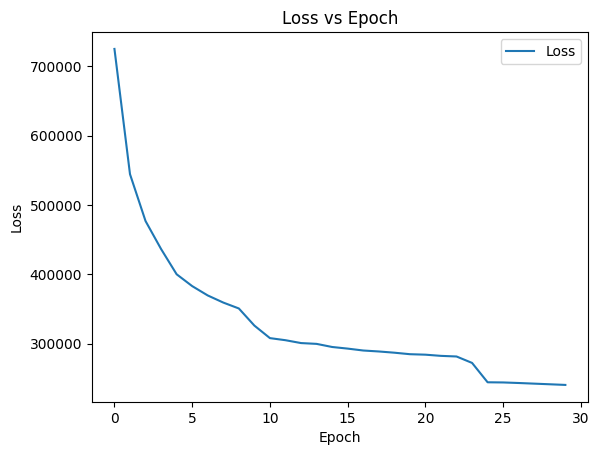

(6912441, 9299040)

In [98]:
# Entrenamos el modelo generador de vectores
w2v_model_cbow.train(sentence_tokens,
                 total_examples=w2v_model_cbow.corpus_count,
                 epochs=30,
                 compute_loss = True,
                 callbacks=[callback()]
                 )

Se vuelven a probar los 3 ejemplos anteriores

In [100]:
# Palabras que MÁS se relacionan con...:
w2v_model_cbow.wv.most_similar(positive=["rice"], topn=10)

[('slow', 0.5512903928756714),
 ('beans', 0.542225182056427),
 ('pasta', 0.5232371687889099),
 ('wine', 0.5212426781654358),
 ('eggplants', 0.5051391124725342),
 ('lentils', 0.4867338240146637),
 ('boiling', 0.47734546661376953),
 ('chickpeas', 0.47449204325675964),
 ('gravy', 0.4606489837169647),
 ('grits', 0.4578205347061157)]

- En este caso los términos relacionados no tienen tanto sentido, quizás "slow" y "boiling" por el tipo de cocción o "wine" por la bebida para acompañar una comida hecha con arroz.
- Sin embargo vuelven a aparecer otras palabras en común como "lentils" y "pasta".

In [101]:
# Palabras que MENOS se relacionan con...:
w2v_model_cbow.wv.most_similar(negative=["oven"], topn=10)

[('adds', 0.4377403259277344),
 ('bright', 0.38836947083473206),
 ('tunisian', 0.38413798809051514),
 ('100g', 0.3780696988105774),
 ('leafy', 0.3760857880115509),
 ('preserved', 0.37195470929145813),
 ('by', 0.3712976276874542),
 ('gallo', 0.3559354841709137),
 ('semi', 0.3530730605125427),
 ('2oz', 0.350665807723999)]

Ninguna de las palabras parece tener mucha relación con oven, lo cual tiene sentido en el contexto de la cocina.*italicized text*

In [103]:
# Palabras que MÁS se relacionan con...:
w2v_model_cbow.wv.most_similar(positive=["bread"], topn=6)

[('liqueur', 0.5151645541191101),
 ('financiers', 0.5054951310157776),
 ('breadcrumbs', 0.5048317313194275),
 ('sourdough', 0.48013368248939514),
 ('kheer', 0.4629851281642914),
 ('biscuit', 0.4615136682987213)]

- Nuevamente, los resultados obtenidos con el modelo de Skipgram parecen más precisos.
- Pero se vuelve a repetir alguna palabra en común con respecto al modelo anterior, como "sourdough".

Ahora se prueba qué pasa si se elige como palabra más similar "meat" y como menos similar "raw"

In [164]:
w2v_model.wv.most_similar(positive=["meat"], negative=["raw"])

[('venison', 0.4655616283416748),
 ('burning', 0.41729360818862915),
 ('240c', 0.4029141366481781),
 ('stew', 0.3991469740867615),
 ('pot', 0.3938199579715729),
 ('lamb', 0.39286723732948303),
 ('ºf', 0.38742998242378235),
 ('spare', 0.38580527901649475),
 ('tenderise', 0.3782281279563904),
 ('450ºf', 0.3770527243614197)]

Puede observarse que los términos que aparecen son relacionados con la cocción de carna y con las altas temperaturas.

### 3. Plantear y probar tests de analogías.

Caso 1: se realizará el siguiente test:

- $grilled - stake \simeq boiled - potatoes$

In [168]:
from sklearn.metrics.pairwise import cosine_similarity

cosine_similarity(
                  (w2v_model.wv.get_vector("grilled") - w2v_model.wv.get_vector("steak")).reshape(1,-1),
                  (w2v_model.wv.get_vector("boiled") - w2v_model.wv.get_vector("potatoes")).reshape(1,-1)
                  )[0][0]

0.30406588

Se ve que la similaridad coseno no es tan grande pero llega a valores cercanos a los que se tenían en las últimas palabras del top 10 al buscar relaciones en el apartado anterior.

Caso 2: se realizará el siguiente test:

- $sushi - japan \simeq kimchi - korea$

In [171]:
from sklearn.metrics.pairwise import cosine_similarity

cosine_similarity(
                  (w2v_model.wv.get_vector("sushi") - w2v_model.wv.get_vector("japan")).reshape(1,-1),
                  (w2v_model.wv.get_vector("kimchi") - w2v_model.wv.get_vector("korea")).reshape(1,-1)
                  )[0][0]

0.3264291

Nuevamente, se obtiene un valor cercano a 0.3

Ahora se plantea un test de hipótesis con una relación sin sentido para ver la similaridad coseno:

- $cossim(pasta - meat, eggs - little)$

In [172]:
cosine_similarity(
                  (w2v_model.wv.get_vector("pasta") - w2v_model.wv.get_vector("meat")).reshape(1,-1),
                  (w2v_model.wv.get_vector("eggs") - w2v_model.wv.get_vector("little")).reshape(1,-1)
                  )[0][0]

-0.03421502

El resultado es un número muy pequeño lo que indica muy poca relación entre ambos vectores.

### 4. Graficar los embeddings resultantes

- Se utiliza t-sne como técnica de reducción de dimensionalidad de los vectores.
- Se reducen a 2 dimensiones y a 3 dimensiones

In [122]:
from sklearn.manifold import TSNE
import numpy as np

def reduce_dimensions(model, num_dimensions = 2 ):

    vectors = np.asarray(model.wv.vectors)
    labels = np.asarray(model.wv.index_to_key)

    tsne = TSNE(n_components=num_dimensions, random_state=0)
    vectors = tsne.fit_transform(vectors)

    return vectors, labels

In [123]:
# Graficar los embedddings en 2D
import plotly.graph_objects as go
import plotly.express as px

vecs, labels = reduce_dimensions(w2v_model)

MAX_WORDS=200
fig = px.scatter(x=vecs[:MAX_WORDS,0], y=vecs[:MAX_WORDS,1], text=labels[:MAX_WORDS])
fig.show(renderer="colab") # esto para plotly en colab

Se observan relaciones interesantes de palabras cercanas como:
- "chicken" y "meat"
- "roll" y "dough"
- "pan", "pot" y "bowl"
- Los números cerca de "minutes"
- "directions" y "instructions"


In [124]:
# Graficar los embedddings en 3D

vecs, labels = reduce_dimensions(w2v_model,3)

fig = px.scatter_3d(x=vecs[:MAX_WORDS,0], y=vecs[:MAX_WORDS,1], z=vecs[:MAX_WORDS,2],text=labels[:MAX_WORDS])
fig.update_traces(marker_size = 2)
fig.show(renderer="colab") # esto para plotly en colab

### 5. Obtener conclusiones

- Dependiendo la fuente del texto y qué resultado se busca puede ser útil hacer un pre-procesamiento para eliminar caracteres que no son de interés.
- El modelo con Skip-gram mostró una precisión mayor que el modelo con CBOW.
- Se puede conocer qué calidad tienen los embeddings y el dataset utilizado con algunas pruebas:
  - A través de analizar palabras similares (similitud coseno ente vectores).
  - Tests de analogías.
- Resulta muy útil realiar una reducción de dimensionalidad para graficar los vectores. De manera visual y mucho más fácil se ven relaciones entre palabras. Incluso relaciones que no se habían pensado en los apartados anteriores.
